<a href="https://colab.research.google.com/github/Bbuyukyilmaz/ELE492---Image-Processing-Homeworks/blob/main/MT1/Q2/MT1_Q2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/Bbuyukyilmaz/ELE492---Image-Processing-Homeworks.git

Cloning into 'ELE492---Image-Processing-Homeworks'...
remote: Enumerating objects: 140, done.
remote: Counting objects: 100% (137/137), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 140 (delta 58), reused 125 (delta 55), pack-reused 3
Receiving objects: 100% (140/140), 4.67 MiB | 13.06 MiB/s, done.
Resolving deltas: 100% (58/58), done.


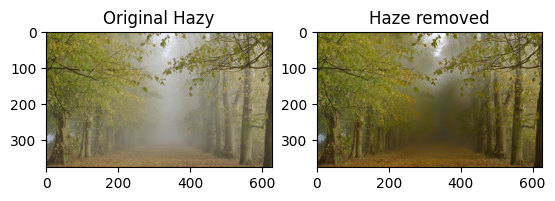

In [2]:
import cv2
import math
import numpy as np
import time
from matplotlib import pyplot as plt

def Dark_channel(img, r):
    win_size = 2 * r + 1
    B, G, R = cv2.split(img)
    temp = cv2.min(cv2.min(B, G), R)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (win_size, win_size))
    dark = cv2.erode(temp, kernel)
    return dark


def AL_estimation(img, dark_channel):
    h, w = img.shape[:2]
    img_size = h * w
    num_pixel = int(max(math.floor(img_size / 1000), 1))

    img_temp = img.reshape(img_size, 3)
    dark_temp = dark_channel.reshape(img_size, 1)

    index = dark_temp[:, 0].argsort()
    index_use = index[img_size - num_pixel:]

    AL_sum = np.zeros([1, 3])
    for i in range(num_pixel):
        AL_sum = AL_sum + img_temp[index_use[i]]

    AL = AL_sum / num_pixel
    thread = np.array([[0.95, 0.95, 0.95]])
    A = cv2.min(AL, thread)
    return A


def Trans_estimation(img, A, r, omega):

    img_temp = np.empty(img.shape, img.dtype)
    for i in range(3):
        img_temp[:, :, i] = img[:, :, i] / A[0, i]
    trans = 1 - omega * Dark_channel(img_temp, r)
    return trans


def Guided_filter(I, p, r, eps):

    mean_I = cv2.boxFilter(I, cv2.CV_64F, (r, r))
    mean_p = cv2.boxFilter(p, cv2.CV_64F, (r, r))
    corr_I = cv2.boxFilter(I * I, cv2.CV_64F, (r, r))
    corr_Ip = cv2.boxFilter(I * p, cv2.CV_64F, (r, r))

    var_I = corr_I - mean_I * mean_I
    cov_Ip = corr_Ip - mean_I * mean_p

    a = cov_Ip / (var_I + eps)
    b = mean_p - a * mean_I

    mean_a = cv2.boxFilter(a, cv2.CV_64F, (r, r))
    mean_b = cv2.boxFilter(b, cv2.CV_64F, (r, r))

    q = mean_a * I + mean_b  #

    return q


def dehaze(img, r, n, thre=0.001, eps=0.0001, omega=0.96):
    img_pro = np.float64(img) / 255
    J_dark = Dark_channel(img_pro, r)
    A = AL_estimation(img_pro, J_dark)
    t = Trans_estimation(img_pro, A, r, omega)

    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_gray = np.float64(img_gray) / 255

    t_ref = Guided_filter(img_gray, t, r * n, eps)

    t_thre = cv2.max(t_ref, thre)
    result = np.empty(img_pro.shape, img_pro.dtype)
    for i in range(3):
        result[:, :, i] = (img_pro[:, :, i] - A[0, i]) / t_thre + A[0, i]

    return result

frame = cv2.imread("/content/ELE492---Image-Processing-Homeworks/MT1/q2_image.jpg")
  
J = dehaze(frame, 5, 10)



fig, ax = plt.subplots(1, 2)
ax[0].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
ax[0].set_title("Original Hazy")
ax[1].imshow(J[:,:,::-1])
ax[1].set_title("Haze removed")
plt.show()